# Topic Model (Latent Dirichlet Allocation)

## 0. Initialize

In [1]:
#text analysis tools
using TextAnalysis
using WordTokenizers
import TinySegmenter
set_tokenizer(TinySegmenter.tokenize)

#python
using PyCall
@pyimport janome.tokenizer as pytk

#mathematics
using SparseArrays

#statistics
using Statistics
using Distributions

#dataframe
using DataFrames

#visualize
using Plots
pyplot()

#macros
using UnPack
using ProgressMeter

## 1. Define functions for preprocessing

In [2]:
#tokenize StringDocument
function my_tokenize(text, stop_words)
    t = pytk.Tokenizer(wakati=true)
    all_tokens = []
    for chr in t.tokenize(text)
        if chr in stop_words
            
        else
            push!(all_tokens, chr)
        end
    end
    return join(all_tokens, "")
end

#clean StringDocument
function clean_text(doc, stop_words)
    text = my_tokenize(doc, stop_words)
    sd = StringDocument(text)
    prepare!(sd, strip_whitespace)
    return sd
end

#load document data
function load_docs(file_path)
    #stop words
    hiragana = ["$(Char(i))" for i in range(12353, 12436, step=1)]
    hiragana2 = [c1*c2 for c1 in hiragana for c2 in hiragana]
    others = ["まず", "次", "的", "法", "よって", "したがって", "従って", "つまり", " ", "-", "ー", "以下", "μ", "λ", "η", "σ", "φ", "₀", "₁", "₂", "₃","α","β","θ","Φ"]
    stop_words = vcat([hiragana, hiragana2, others]...)
    
    sd_list = []
    for doc in eachline(file_path)
        sd = clean_text(doc, stop_words)
        push!(sd_list, sd)
    end
    return sd_list
end

function create_crps(sd_list)
    crps = Corpus(sd_list)
    update_lexicon!(crps)
    
    st = sparse_terms(crps, 0.1)
    remove_words!(crps, st)
    update_lexicon!(crps)
    return crps
end

function transpose_sparse_mat(mat)
    M,N = size(mat)
    mat_t = spzeros(N,M)
    for m in 1:M
        for n in mat[m,:].nzind
            mat_t[n,m] = mat[m,n]
        end
    end
    return mat_t
end

function preprocess(data_path)
    sd_list = load_docs("data.txt")
    crps = create_crps(sd_list)
    DTM = DocumentTermMatrix(crps)
    W_dtm = DTM.dtm
    W = transpose_sparse_mat(W_dtm)
    words_dict = DTM.column_indices
    V, D = size(W)
    return W, words_dict, V, D
end

preprocess (generic function with 1 method)

## 2. Define functions for inference

In [3]:
#normalize vector
function norm_vec(vec)
    vec / sum(vec)
end

function rand_dir(param, d1, d2, d3)
    r = zeros(d1,d2,d3)
    for k in 1:d3
        r[:,:,k] .= rand(Dirichlet(param*ones(d1)), d2)
    end
    return r
end

#sample latent variable z
function sample_z(θd, φv)
    return rand(Categorical(norm_vec(θd .* φv)))
end

#sample topic probability over document
function sample_theta(ndts, d, α)
    return rand(Dirichlet(ndts[:,d] .+ α))
end

#sample word probability over topic
function sample_phi(ntvs, t, β)
   return rand(Dirichlet(ntvs[:,t] .+ β)) 
end

#initialize
function initialize!(Z, Θsamps, Φsamps, ndts, ntvs, W, D, T, α, β)
    #sample z 
    w_count = 0
    for d in 1:D
        for v in W[:,d].nzind
            for _ in 1:W[v,d]
                w_count += 1
                z = sample_z(Θsamps[:,d,1], Φsamps[v,:,1])
                Z[w_count] = z
                ndts[z,d] += 1
                ntvs[v,z] += 1
            end
        end
        
        #sample theta
        Θsamps[:,d,1] .= sample_theta(ndts, d, α)
    end
    
    #sample phi
    for t in 1:T
        Φsamps[:,t,1] .= sample_phi(ntvs, t, β)
    end
end

#Gibbs sampler
function my_Gibbs_sampler(data, model_params, n_samps)
    @unpack W, D, V = data
    @unpack T, α, β = model_params
    
    #initialize
    n_burnin = div(n_samps, 10)
    Θsamps = rand_dir(α, T, D, n_samps) 
    Φsamps = rand_dir(β, V, T, n_samps) 
    Z = zeros(Int, Int(sum(W)))
    ndts = spzeros(T, D); ntvs = spzeros(V, T)
    initialize!(Z, Θsamps, Φsamps, ndts, ntvs, W, D, T, α, β)
    
    @showprogress for s in 2:n_samps
        #sample z and theta
        w_count = 0
        for d in 1:D
            for v in W[:,d].nzind
                for _ in 1:W[v,d]
                    w_count += 1
                    z = Z[w_count]
                    ndts[z,d] -= 1; ntvs[v,z] -= 1
                    
                    #sample z and update
                    z = sample_z(Θsamps[:,d,s-1], Φsamps[v,:,s-1])
                    Z[w_count] = z
                    ndts[z,d] += 1; ntvs[v,z] += 1
                end
            end
            
            #sample theta
            Θsamps[:,d,s] .= sample_theta(ndts, d, α)
        end
        
        #sample phi
        for t in 1:T
            Φsamps[:,t,s] .= sample_phi(ntvs, t, β)
        end
    end
    
    #remove burn-in period
    topic_probs = mean(Θsamps[:,:,n_burnin:end], dims=3)[:,:,1]
    word_probs = mean(Φsamps[:,:,n_burnin:end], dims=3)[:,:,1]
    trained_model = (word_probs=word_probs, topic_probs=topic_probs, Z=Z)
    return trained_model
end

my_Gibbs_sampler (generic function with 1 method)

## 3. Experiment

In [4]:
W, words_dict, V, D = preprocess("data.txt")
data = (W=W, D=D, V=V, words_dict)
model_params = (T=10, α=1e-2, β=1e-2)
n_samps = 500
trained_model = my_Gibbs_sampler(data, model_params, n_samps)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


(word_probs = [0.0030731203676581387 1.0411219546138133e-6 … 4.140112329911465e-5 5.713380751225197e-6; 3.1848163732602784e-6 3.03277844865115e-6 … 7.412267546070748e-7 5.908315252466583e-6; … ; 0.002924532118033383 1.9610889998209462e-5 … 4.348939818002406e-5 3.683509497551611e-6; 1.3689298659296356e-6 2.5568603103576345e-6 … 2.7958805544299105e-6 6.204805555035003e-6], topic_probs = [0.0186805026776744 0.02019157826824011 … 0.08981546545847366 0.04141704319528396; 0.46494647586315524 0.0022603712449542346 … 0.029491322297238838 0.17669035613014888; … ; 0.1402245462598663 0.5464539237189986 … 0.03562442266286158 0.3012613206030048; 8.818564355124799e-5 0.08959048989142376 … 0.5342489280060321 0.018169417302579562], Z = [1, 1, 2, 3, 8, 1, 1, 1, 9, 9  …  3, 8, 8, 7, 9, 9, 9, 7, 8, 8])

## 4. Results

In [5]:
#top words for each topic
function top_topics(data, model_params, n_top, trained_model)
    @unpack words_dict = data
    @unpack T = model_params
    @unpack word_probs = trained_model
    
    #dictionary id -> word
    id2word_dict = Dict(value=>key for (key,value) in words_dict)
    
    #word prob and topic names
    topic_col_names = ["topic_$(t)" for t in 1:T]
    
    #word ranking 
    word_rank = hcat([sortperm(word_probs[:,t], rev=true) for t in 1:T]...)
    word_cols = []
    for col in eachcol(word_rank)
        push!(word_cols, [id2word_dict[col[r]] for r in 1:n_top])
    end
    return DataFrame(hcat(word_cols...), topic_col_names)
end

#plot topics probabilities for each document
function doc_topic_plots(data, trained_model)
    @unpack D = data
    @unpack topic_probs = trained_model
    p_list = []
    for d in Int.(floor.(range(1, D, length=10)))
        p = plot(topic_probs[:,d], st=:bar, legend=false, xlabel="topic_number", ylabel="prob", title="doc $(d)"
            , ylim=(0,0.2))
        push!(p_list, p)
    end
    return plot(p_list..., layout=(2,5), size=(1000,400))
end

doc_topic_plots (generic function with 1 method)

In [6]:
n_top = 10
ENV["COLUMNS"] = 500
top_topics(data, model_params, n_top, trained_model)

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
,String,String,String,String,String,String,String,String,String,String
1,サンプル,分布,として,軌道,実行,単語,関数,分布,コード,空間
2,分布,モデル,平均,プロット,コマンド,トピック,加速,近似,結果,ベクトル
3,計算,データ,考え,周期,結果,確率,コスト,推論,実行,コード
4,に,予測,パラメータ,写像,ファイル,言語,問題,変分,計算,行列
5,微分,事後,推測,コード,作成,出現,適用,事後,実験,直交
6,アルゴリズム,推定,用い,方程,う,し,訓練,確率,に,近似
7,という,真分,過程,保存,基本,指数,ば,正規,データ,最小
8,て,計算,期待,解析,利用,結果,勾配,学習,記事,方程
9,構成,過程,数値,不動,表示,生成,誤差,コード,数,探索


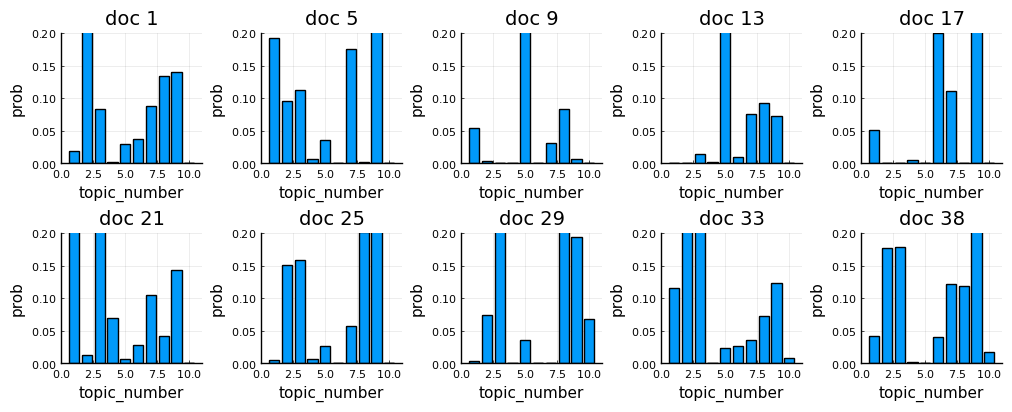

In [7]:
fig = doc_topic_plots(data, trained_model)
savefig(fig, "fig.png")